# How To Forecast Time-Series Using SARIMA


## Intro


In one of my previous posts we covered probably the most famous forecasting model, Autoregressive Integrated Moving Average better known as ARIMA. However, one disadvantage of this model is that it is lacking awareness of any seasonality. This is where the Seasonal Autoregressive Integrated Moving Average, or SARIMA, model comes in. In this post, we will take a deep dive into the theory and main ideas behind the SARIMA model and how to implement it in Python.

## What Is SARIMA



### Overview

SARIMA is an extension of the regular ARIMA model that adds a seasonality component to the model. This allows us to better capture seasonal affects that the regular ARIMA model does not permit.

### Theory

The classic ARIMA model has three components: Autoregressive, Integrated (differencing), and Moving-Average. These are then linearly combined to form the model:

$$
y_t' = c + \sum_{n=1}^{p} \phi_n y_{t-n}' + \sum_{n=1}^{q} \theta_n \epsilon_{t-n} + \epsilon_t
$$

Where:
- y’: differenced time series, the number of differencing applied is noted as d
- ϕ: coefficients of the autoregressive components (lags)
- p: number of autoregressive components
- ε: forecast error terms, the moving-average components
- θ: coefficients of the lagged forecast errors
- q: number of lagged error components

The model is often compactly written ARIMA(p, d, q) where p, d, and q refer to the order of autoregressors, differencing and moving-average components respectively.

ed forecast errors
- q: number of lagged error components

The model is often compactly written ARIMA(p, d, q) where p, d, and q refer to the order of autoregressors, differencing and moving-average components respectively.

SARIMA adds a seasonality component to each factor of the ARIMA equation to produce SARIMA(p, d, q)(P, D, Q)m:

$$
y_t' = c + \sum_{n=1}^{p} \phi_n y_{t-n}' + \sum_{n=1}^{q} \theta_n \epsilon_{t-n} 
      + \sum_{n=1}^{P} \eta_n y_{t-mn}' + \sum_{n=1}^{Q} \omega_n \epsilon_{t-mn} + \epsilon_t
$$

Where:
- y’: differenced time series, through both regular, d, and seasonal, D, differencing
- P: number of seasonal auto-regressors
- ω: coefficients of the seasonal autoregressive components
- Q: number of seasonal moving-average components
- η: coefficients of the seasonal forecast errors
- m: length of season

### Requirements

Like the original ARIMA model, the SARIMA model needs to have stationary data to model and forecast the time series. A stationarity time series does not exhibit any long-term trend or clear seasonality, its statistical properties, such as mean and variance, remain constant over time.

To produce a stationary time series we need to stabilize the mean and variance. The mean can be stabilized through differencing and the number of differencing applied is d or D in the case of seasonal differencing. The variance can be stabilized through transformations such as the logarithmic and Box-Cox transform, this makes the seasonal fluctuations occur on a similar level every season.

### Order Selection

After the time series is stationary, we then need to deduce the best orders, (p, d, q) and (P, D, Q)m, for our model. The simplest one to calculate is the seasonal, D, and regular differencing, d. This can be deduced through the Augmented Dickey-Fuller (ADF) statistical test that deduces whether a time series is stationary or not.

The autoregressive and moving-average (forecast errors) orders (p, q, P, Q) can be computed by analyzing the partial autocorrelation function (PACF) and autocorrelation function respectively. The idea behind this technique is to plot a correlogram of the autoregressors and moving-average value and deduce which ones are statistically significant. The significant ones indicate that they have a substantial impact on the forecast.

These correlograms will also allow us to observe the seasonal pattern if any, as we may see peaks at certain multiple lags. For example, a SARIMA(0,0,0)(1,0,0)4 will show exponential decay in the lags for the ACF but a significant spike at lag 4 in the PACF. If the data is indexed by month, then this is would be an example of quarterly seasonality.

### Estimation

The final step is to compute the corresponding coefficients for these orders. The most common method is to use Maximum Likelihood Estimation (MLE) which estimates the coefficients against some assumed probability distribution, typically normal, to calculate which coefficient is the most likely to generate that data. As the time series is stationary and has constant statistical properties, we can say that it belongs to some probability distribution allowing us to use MLE. This is why stationarity is the key requirement for SARIMA.

## Python Walkthrough



### Data

/Users/amirashrafizham/Desktop/Machine Learning Projects/time-series/time-series-models/statisticalmodel/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


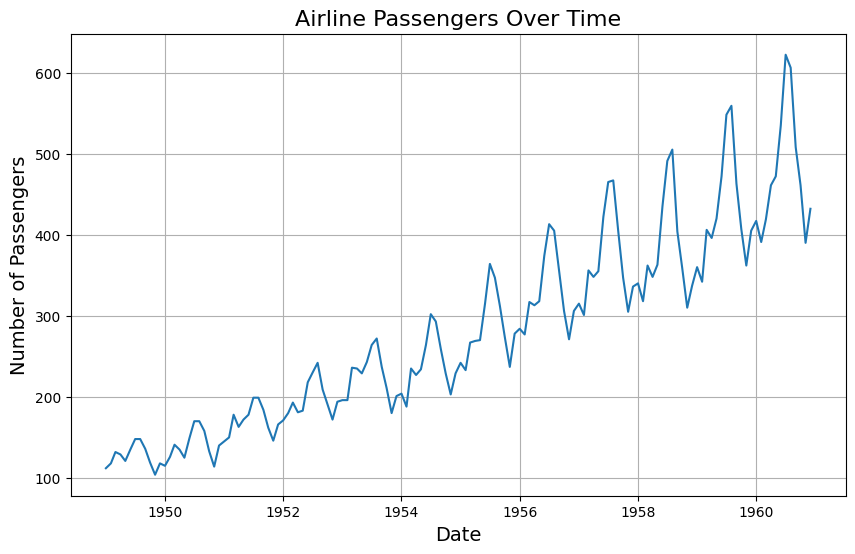

In [1]:
# Import packages
import plotly.express as px
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt

# Read in the data
path = kagglehub.dataset_download("ashfakyeafi/air-passenger-data-for-time-series-analysis")
data = pd.read_csv(path + "/AirPassengers.csv")
data['Month'] = pd.to_datetime(data['Month'])


def plot_passenger_volumes(df: pd.DataFrame,
                           y: str) -> None:

    plt.figure(figsize=(10, 6))
    plt.plot(df['Month'], df[y])
    plt.title('Airline Passengers Over Time', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Number of Passengers', fontsize=14)
    plt.grid(True)
    plt.show()    


# Plot the airline passenger data
plot_passenger_volumes(df=data, y='#Passengers')

There is an obvious trend and seasonality, so the data is not stationary as the mean and variance is changing over time. Therefore, we need to apply differencing and the Box-Cox transform to make our series stationary as required by SARIMA:

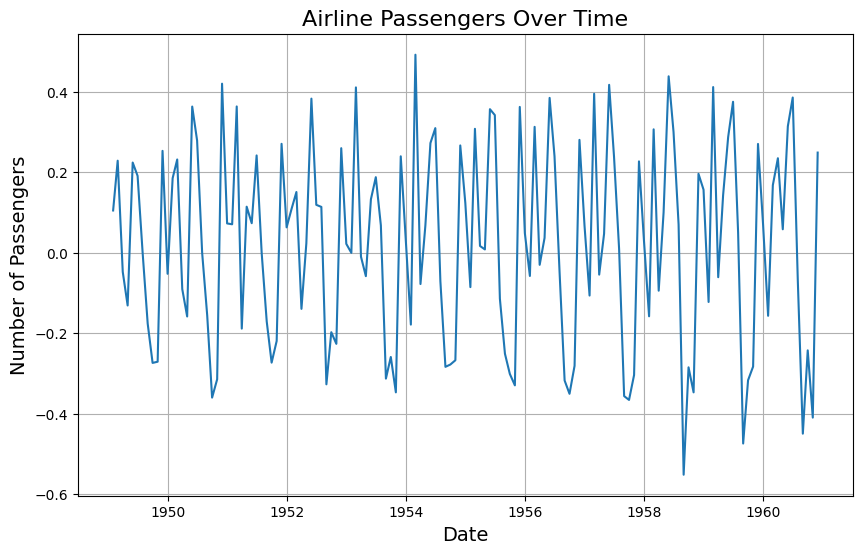

In [2]:
# Import packages
from scipy.stats import boxcox

# Make the data stationary
data['Passengers_Boxcox'], lam = boxcox(data['#Passengers'])
data["Passenger_diff"] = data["Passengers_Boxcox"].diff()
data.dropna(inplace=True)

# Plot the stationary passenger data
plot_passenger_volumes(df=data, y='Passenger_diff')

The data now looks sufficiently stationary.


### Modelling

We will now use the ACF and PACF correlograms to deduce the orders for the autoregressive and moving-average components:

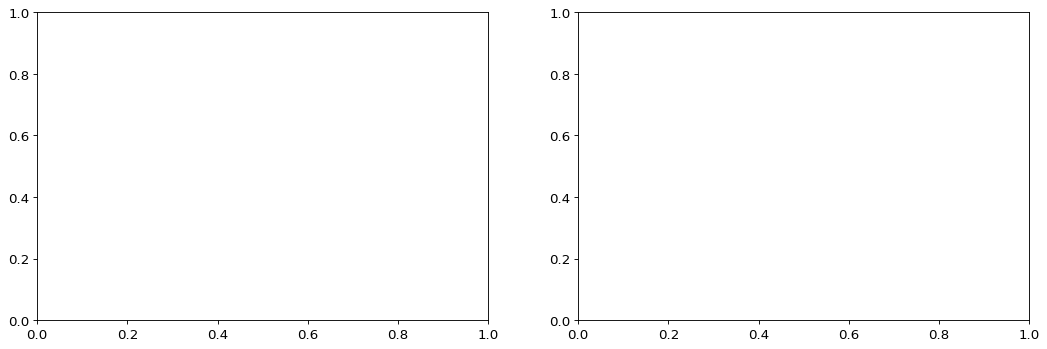

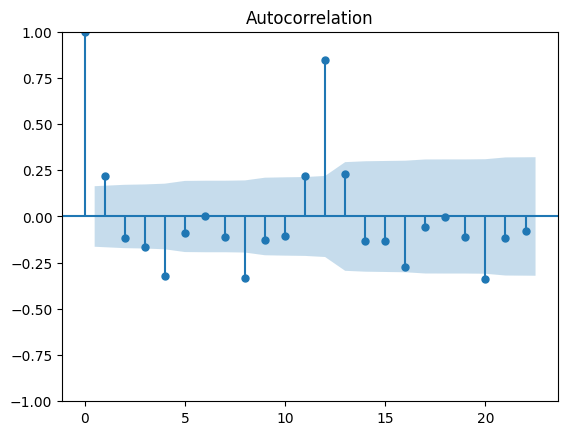

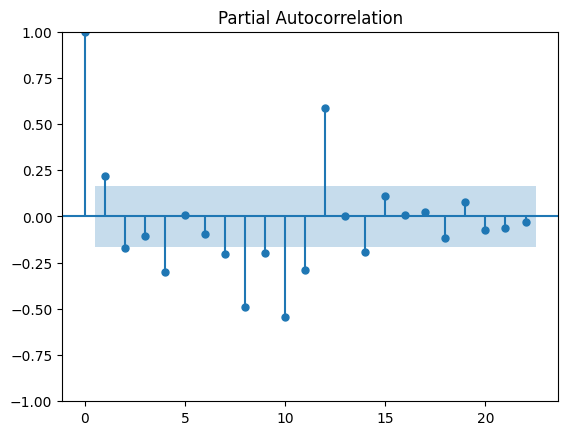

In [3]:
# Import packages
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Plot acf and pacf
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), dpi=80)
plot_acf(data['Passenger_diff'])
plot_pacf(data['Passenger_diff'], method='ywm')
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
plt.show()

We already observed that our series yearly seasonality, m=12, but the above plots confirm this as we have large spikes at the 12th lags. The lags are also significant to around ~10th lag for both plots. Overall this indicates that a SARIMA(10, 1, 10)(1, 1, 1)12 model should be suitable.

Now, let’s fit the model using the ARIMA class from statsmodels and generate the forecasts. Luckily, this class carries out differencing for us, so we only need to pass the Box-Cox transformed time series:

In [4]:
# Import packages
from scipy.special import inv_boxcox
from statsmodels.tsa.arima.model import ARIMA

# Split train and test
train = data.iloc[:-int(len(data) * 0.2)]
test = data.iloc[-int(len(data) * 0.2):]

# Build ARIMA model
model = ARIMA(train['Passengers_Boxcox'], order=(10, 1, 10),
              seasonal_order=(1, 1, 1, 12)).fit()
boxcox_forecasts = model.forecast(len(test))
forecasts = inv_boxcox(boxcox_forecasts, lam)

/Users/amirashrafizham/Desktop/Machine Learning Projects/time-series/time-series-models/statisticalmodel/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/amirashrafizham/Desktop/Machine Learning Projects/time-series/time-series-models/statisticalmodel/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/amirashrafizham/Desktop/Machine Learning Projects/time-series/time-series-models/statisticalmodel/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a resul

### Results

Finally, we will plot the forecasts:

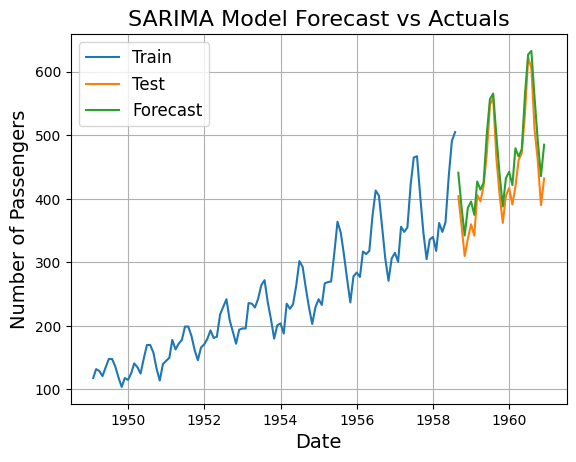

In [6]:
# Import packages
import plotly.graph_objects as go

def plot_forecasts(forecasts: list[float], title: str) -> None:
    
    plt.Figure(figsize=(10, 6))
    plt.plot(train['Month'], train['#Passengers'], label='Train')
    plt.plot(test['Month'], test['#Passengers'], label='Test')
    plt.plot(test['Month'], forecasts, label='Forecast')
    plt.title(f'{title} Model Forecast vs Actuals', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Number of Passengers', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()


# Plot the forecasts
plot_forecasts(forecasts, 'SARIMA')

The SARIMA forecasts seemed to have done quite well!
